### <center>Chestnut Bur Detection and Segmentation using MaskRCNN in PyTorch</center>

In [1]:
%matplotlib inline

import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision
from torchvision import transforms as _transforms, tv_tensors
import torchvision.transforms.v2 as T
from torchvision.transforms import functional as F
import json
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
import gc
import os
from PIL import Image, ImageDraw, ImageOps

from segmentation_pytorch import engine

In [2]:
gc.collect()
torch.cuda.empty_cache()

##### <center> Load the image and annotation data </center>

In [3]:
# load annotations from json file
# annos = json.load(open("C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/_annotations.coco.json"))
annos = json.load(open("S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/_annotations.coco.json"))

In [4]:
# convert the annos dict to a df
annos_df = pd.DataFrame(annos["annotations"])
df = pd.DataFrame()
df["tree_id"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"].split("_")[0])
df["file_name"] = annos_df["image_id"].apply(lambda x: annos["images"][x]["file_name"])
df["file_name"] = df["file_name"].apply(lambda x: x.split("_")[0] + ".png")
categories = [cat["name"] for cat in annos["categories"]]
df["category_name"] = annos_df["category_id"].apply(lambda x: categories[x])
df["bbox"] = annos_df["bbox"].apply(lambda x: torch.tensor(x))
df["area"] = annos_df["area"].apply(lambda x: torch.tensor(x))
df["segmentation"] = annos_df["segmentation"].apply(lambda x: torch.tensor(x))
df["iscrowd"] = annos_df["iscrowd"]

# Filter df to remove treeIds not reviewed. 
reviewed_trees = [
    14, 44, 51, 60, 79, 91, 92, 117, 118, 146, 152, 171, 
    172, 210, 272, 276, 280, 286, 304, 309, 320, 329, 
    366, 369, 371, 392, 394, 405
]

df = df[df["tree_id"].isin([str(tree_id) for tree_id in reviewed_trees])]

In [5]:
image_dir = "S:/Zack/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/images"
image_names = df["file_name"].unique()
# mask_dir = "C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/data/masks"

In [6]:
# # plot each image with its canopy polygon mask and chestnut polygon masks

# os.makedirs("C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/annotated_images", exist_ok=True)

# for i, tree_id in enumerate(df["tree_id"].unique()):
#     image_file = Path(image_dir) / df[df["tree_id"] == tree_id]["file_name"].values[0]
#     image = Image.open(image_file)
#     # get image width and height
#     width, height = image.size

#     # print(f"tree {tree_id} has a width of {width} and height of {height} pixels")

#     canopy_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "Canopy")]["segmentation"].values
#     bur_poly = df[(df["tree_id"] == tree_id) & (df["category_name"] == "Chestnut-burr")]["segmentation"].values

#     canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
#     bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

#     # Create a drawing context
#     draw = ImageDraw.Draw(image)
    
#     for poly in canopy_poly:
#         draw.polygon([tuple(point) for point in poly], outline="purple", width=2)
#     for poly in bur_poly:
#         draw.polygon([tuple(point) for point in poly], outline="red")

#     # Save the image
#     image.save(f"C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/annotated_images/{tree_id}_annotated.png", format='PNG')

##### <center> Pre-process and transform image and annotation data </center>

##### Adapted from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#an-instance-segmentation-model-for-pennfudan-dataset

In [7]:
def mask_fill(mask, polys, color):
    from cv2 import fillPoly
    for poly in polys:
        fillPoly(mask, [poly], color)
    return mask

In [8]:
class ChestnutBurSegmentation(Dataset):
    """Custom Dataset for Chestnut Bur Segmentation in UAV Images"""

    def __init__(self, image_dir, df, transform=None, tile_size=512):
        self.image_dir = image_dir
        self.df = df
        self.transform = transform
        self.tile_size = tile_size
        self.tiles = self.create_tile_indices()

    def create_tile_indices(self):
        tile_indices = []
        for tree_id in self.df["tree_id"].unique():
            canopy_poly = self.df[(self.df["tree_id"] == tree_id) & (self.df["category_name"] == "Canopy")]["segmentation"].values
            canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]

            # get canopy_bbox coords [xmin, ymin, xmax, ymax]
            xmin, ymin, xmax, ymax = min([poly[:, 0].min() for poly in canopy_poly]), min([poly[:, 1].min() for poly in canopy_poly]), max([poly[:, 0].max() for poly in canopy_poly]), max([poly[:, 1].max() for poly in canopy_poly])

            # Calculate the center of the canopy
            center_x = (xmin + xmax) // 2
            center_y = (ymin + ymax) // 2

            # Calculate the number of tiles for the clipped image
            clipped_height = ymax - ymin
            clipped_width = xmax - xmin
            num_tiles_y = (clipped_height + self.tile_size - 1) // self.tile_size
            num_tiles_x = (clipped_width + self.tile_size - 1) // self.tile_size

            # Calculate the starting tile indices to center the first tile on the canopy center
            start_tile_x = max(0, (center_x - xmin) // self.tile_size - num_tiles_x // 2)
            start_tile_y = max(0, (center_y - ymin) // self.tile_size - num_tiles_y // 2)

            for tile_y in range(start_tile_y, start_tile_y + num_tiles_y):
                for tile_x in range(start_tile_x, start_tile_x + num_tiles_x):
                    tile_indices.append((tree_id, tile_y, tile_x, xmin, ymin, xmax, ymax))
        return tile_indices

    def __getitem__(self, idx):
        tree_id, tile_y, tile_x, xmin, ymin, xmax, ymax = self.tiles[idx]
        row = self.df[self.df["tree_id"] == tree_id].iloc[0]
        image_file = Path(self.image_dir) / row["file_name"]

        # Calculate the tile coordinates
        tile_xmin = xmin + tile_x * self.tile_size
        tile_ymin = ymin + tile_y * self.tile_size
        tile_xmax = min(tile_xmin + self.tile_size, xmax)
        tile_ymax = min(tile_ymin + self.tile_size, ymax)

        # Load only the required tile
        with Image.open(image_file) as img:
            img_tile = img.crop((tile_xmin, tile_ymin, tile_xmax, tile_ymax)).convert("RGB")
            img_tile = np.array(img_tile)

        # Pad the tile if necessary
        pad_height = self.tile_size - (tile_ymax - tile_ymin)
        pad_width = self.tile_size - (tile_xmax - tile_xmin)

        img_tile = np.pad(img_tile, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)

        # Filter the DataFrame once for the tree_id
        tree_df = self.df[self.df["tree_id"] == tree_id]
        canopy_poly = tree_df[tree_df["category_name"] == "Canopy"]["segmentation"].values
        bur_poly = tree_df[tree_df["category_name"] == "Chestnut-burr"]["segmentation"].values

        canopy_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in canopy_poly]
        bur_poly = [np.array(poly[0]).reshape(-1, 2).astype(np.int32) for poly in bur_poly]

        # Create the canopy mask
        canopy_mask = np.zeros((self.tile_size, self.tile_size), dtype=np.uint8)
        canopy_poly_tile = [poly - [tile_xmin, tile_ymin] for poly in canopy_poly]
        canopy_mask_tile = mask_fill(canopy_mask, canopy_poly_tile, 1)

        # Apply canopy mask to the image
        img_tile = img_tile * canopy_mask_tile[..., np.newaxis]

        # Change the background color to pink
        img_tile[canopy_mask == 0] = [255, 105, 180] # pink RGB

        # Create the masks for the tile
        bur_masks = []
        for poly in bur_poly:
            # Create the bur mask with the same coordinates as the tile
            bur_mask = np.zeros((self.tile_size, self.tile_size), dtype=np.uint8)
            bur_mask = mask_fill(bur_mask, [poly - [tile_xmin, tile_ymin]], 1)
            bur_mask_tile = bur_mask[:tile_ymax - tile_ymin, :tile_xmax - tile_xmin]

            # Pad the bur mask if necessary
            bur_mask_tile = np.pad(bur_mask_tile, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
            bur_masks.append(bur_mask_tile)

        # Check if the tile contains any canopy
        if len(canopy_poly_tile) == 0:
            return None  # Exclude empty tiles

        # Stack the bur masks
        mask_image = np.stack(bur_masks, axis=0)

        # transpose to (C, H, W)
        mask_image.transpose(1, 2, 0)
        mask_image = tv_tensors.Mask(mask_image)

        # Filter the target features for the tile
        labels = tree_df[tree_df["category_name"] == "Chestnut-burr"]["category_name"].values
        labels = [categories.index(label) for label in labels]
        bboxes = tree_df[tree_df["category_name"] == "Chestnut-burr"]["bbox"].values
        bboxes = [torch.tensor([bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]], dtype=torch.float32) for bbox in bboxes]
        bboxes = torch.stack([bbox for bbox in bboxes], dim=0)
        area = tree_df[tree_df["category_name"] == "Chestnut-burr"]["area"].values
        iscrowd = tree_df[tree_df["category_name"] == "Chestnut-burr"]["iscrowd"].values

        # Adjust bounding boxes and labels for the tile
        bbox_tile, label_tile, area_tile, iscrowd_tile, mask_tile = self.filter_bboxes_and_masks_for_tile(bboxes, labels, area, iscrowd, mask_image, tile_ymin, tile_xmin)

        # Process the tile
        img_tile = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True),
                              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])(img_tile)

        # Create new image_id for the tile
        image_id_tile = f"{tree_id}_tile{tile_y}_{tile_x}"  # Keep image_id as a string

        target = {
            "boxes": bbox_tile,
            "labels": label_tile,
            "image_id": image_id_tile,
            "area": area_tile,
            "iscrowd": iscrowd_tile,
            "masks": mask_tile
        }

        return img_tile, target

    def filter_bboxes_and_masks_for_tile(self, bboxes, labels, areas, iscrowds, mask_tile, i, j):
        """Filter bounding boxes, labels, areas, iscrowds, and masks for a tile."""
        bbox_tile = []
        label_tile = []
        area_tile = []
        iscrowd_tile = []
        mask_tile_list = []

        for idx, (bbox, label, area, iscrowd) in enumerate(zip(bboxes, labels, areas, iscrowds)):
            x_min, y_min, x_max, y_max = bbox
            if (x_min < j + self.tile_size and x_max > j and y_min < i + self.tile_size and y_max > i):
                # Adjust coordinates to be relative to the tile
                x_min = max(x_min - j, 0)
                x_max = min(x_max - j, self.tile_size)
                y_min = max(y_min - i, 0)
                y_max = min(y_max - i, self.tile_size)
                bbox_tile.append([x_min, y_min, x_max, y_max])
                label_tile.append(label)
                area_tile.append(area)
                iscrowd_tile.append(iscrowd)
                mask_tile_list.append(mask_tile[idx])  # Use the mask directly

        if bbox_tile:
            bbox_tile = torch.tensor(bbox_tile, dtype=torch.float32)
            label_tile = torch.tensor(label_tile, dtype=torch.int64)
            area_tile = torch.tensor(area_tile, dtype=torch.float32)
            iscrowd_tile = torch.tensor(iscrowd_tile, dtype=torch.int64)
            mask_tile = torch.stack(mask_tile_list)
        else:
            bbox_tile = torch.zeros((0, 4), dtype=torch.float32)
            label_tile = torch.zeros((0,), dtype=torch.int64)
            area_tile = torch.zeros((0,), dtype=torch.float32)
            iscrowd_tile = torch.zeros((0,), dtype=torch.int64)
            mask_tile = torch.zeros((0, self.tile_size, self.tile_size), dtype=torch.float32)

        return bbox_tile, label_tile, area_tile, iscrowd_tile, mask_tile

    def __len__(self):
        return len(self.tiles)

    @staticmethod
    def collate_fn(batch):
        batch = list(filter(lambda x: x is not None, batch))  # Exclude empty tiles
        return tuple(zip(*batch))

In [9]:
# define transforms for the dataset
def get_transform(train):
    transforms = []
    
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ClampBoundingBoxes()) # for segmentations too
    transforms.append(T.SanitizeBoundingBoxes()) ## for segmentations too

    return T.Compose(transforms)

In [ ]:
sample_ds = ChestnutBurSegmentation(image_dir, df, get_transform(train = False))

sample_dl = DataLoader(sample_ds, 
                       batch_size = len(sample_ds), 
                       shuffle = True, 
                       collate_fn = ChestnutBurSegmentation.collate_fn)

In [11]:
images, targets = next(iter(sample_dl))
images = [img for img in images]
targets = [{k: v for k, v in target.items()} for target in targets]

##### <center> Plot sample transformed images, targets, and masks </center>

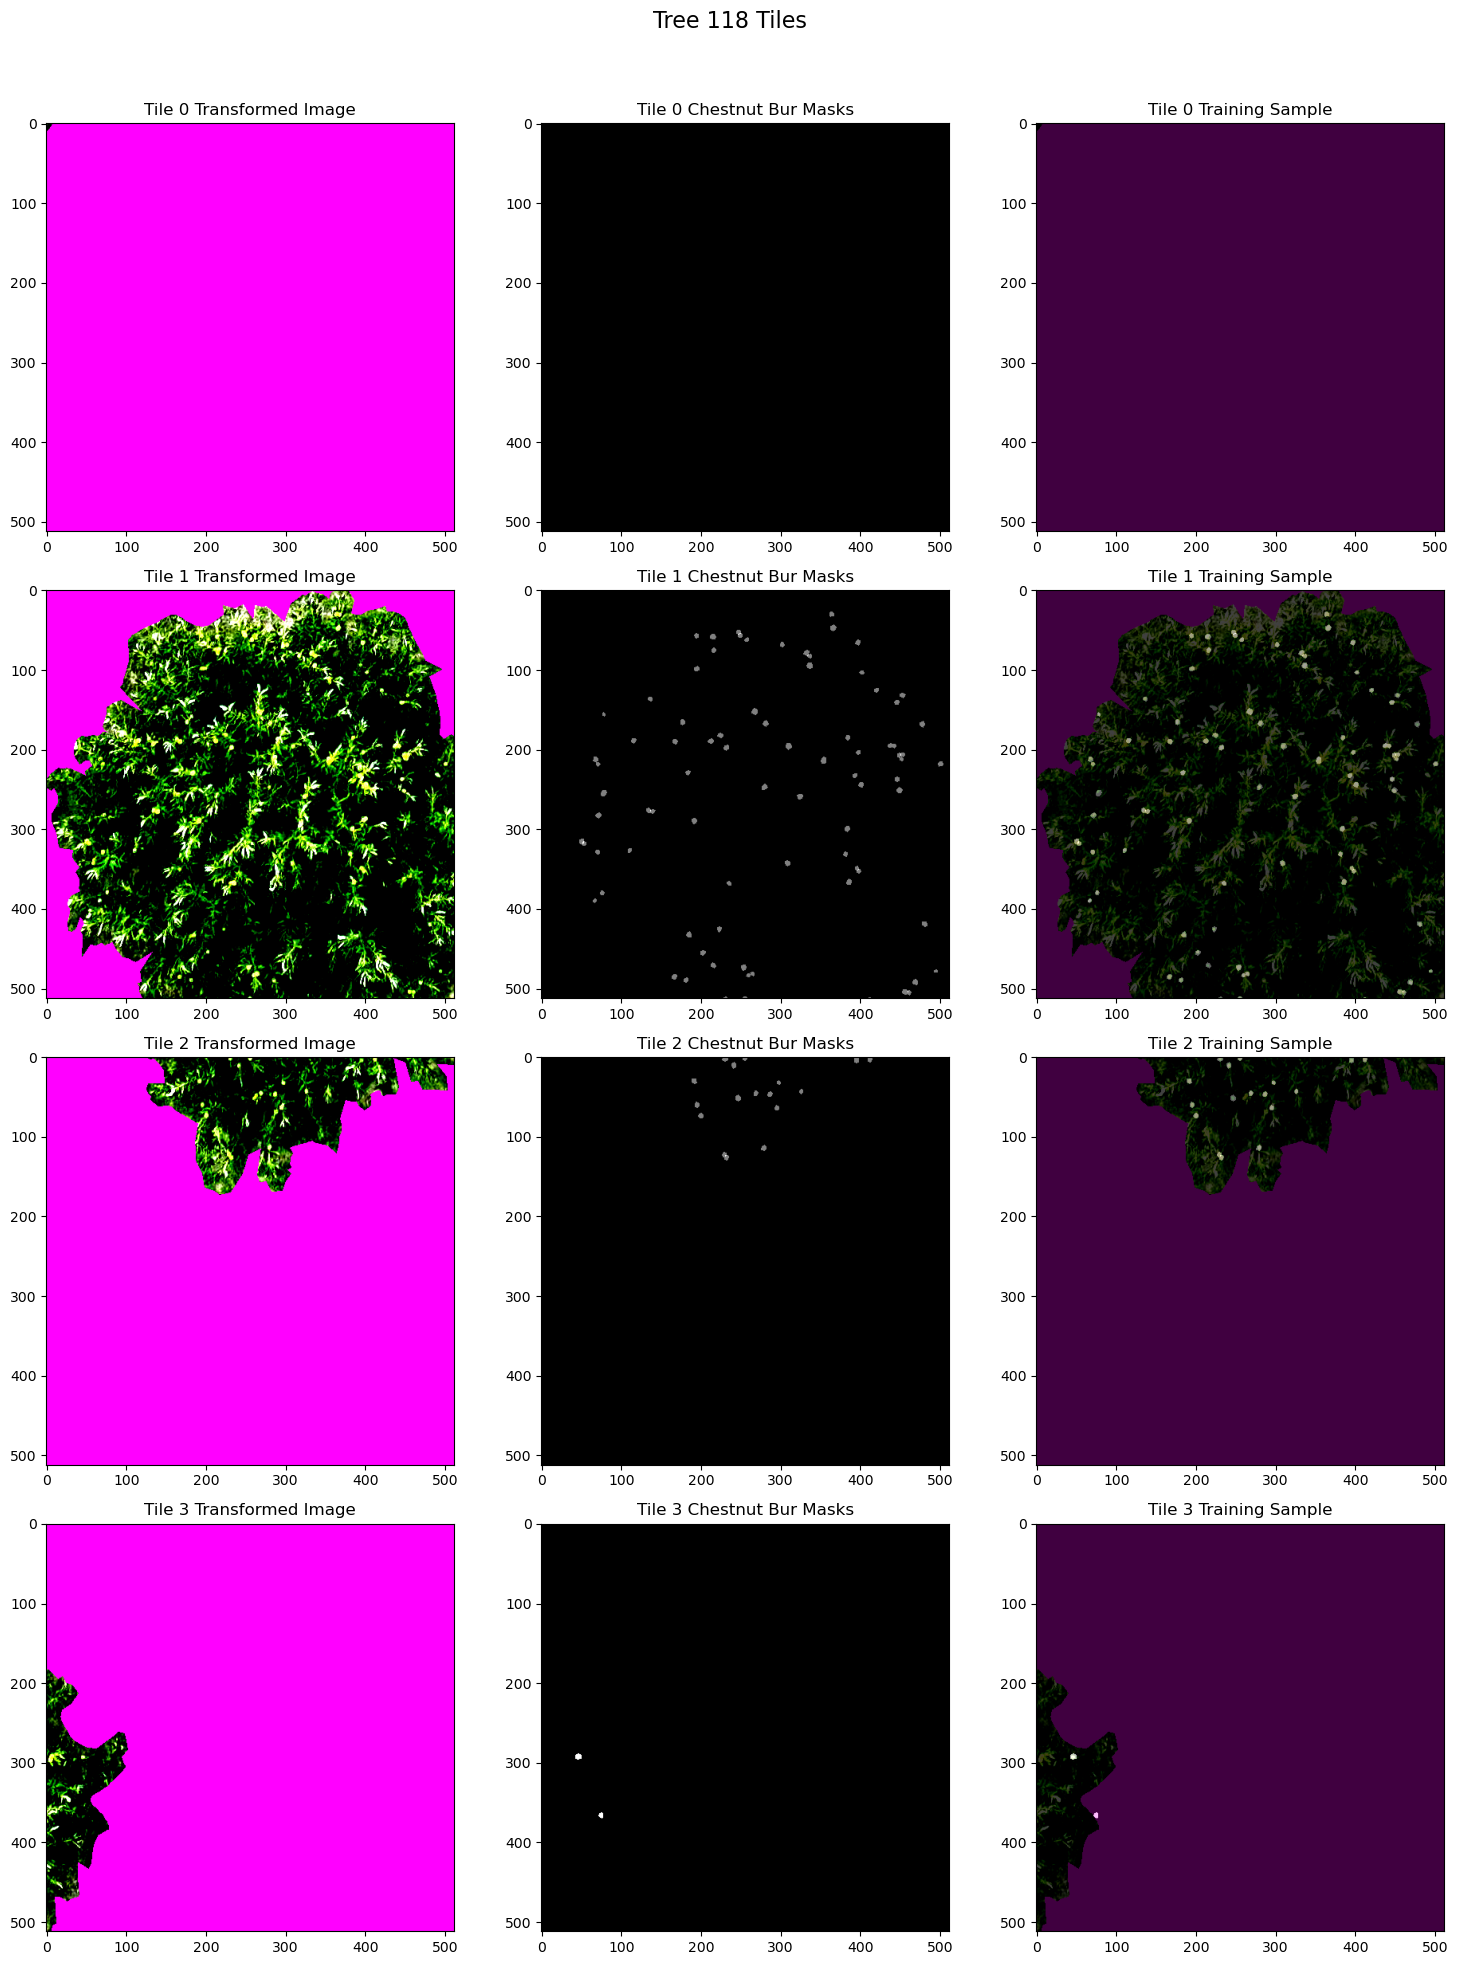

In [12]:
%matplotlib inline
def plot_images_by_tree(images, targets):
    # Group images and targets by tree ID
    tree_dict = {}
    
    for image, target in zip(images, targets):
        tree_id = target["image_id"].split('_')[0]
        if tree_id not in tree_dict:
            tree_dict[tree_id] = {"images": [], "targets": []}
        tree_dict[tree_id]["images"].append(image)
        tree_dict[tree_id]["targets"].append(target)

    # Plot images, masks, and image with mask overlay for each tree
    n_trees_plot = 1
    
    for tree_id, data in list(tree_dict.items())[:int(n_trees_plot)]: # first two trees
        images = data["images"]
        targets = data["targets"]
        fig, ax = plt.subplots(len(images), 3, figsize=(15, 5*len(images)))
        fig.suptitle(f"Tree {tree_id} Tiles", fontsize=16)
        for i, (image, target) in enumerate(zip(images, targets)):
            image = image.permute(1, 2, 0).cpu().numpy()
            mask = target["masks"].permute(1, 2, 0).cpu().numpy()

            # Clip the image data to the valid range [0, 1] for floats
            image = np.clip(image, 0, 1)

            ax[i, 0].imshow(image)
            ax[i, 0].set_title(f"Tile {i} Transformed Image")
            ax[i, 1].imshow(mask.sum(axis=2), cmap="gray")
            ax[i, 1].set_title(f"Tile {i} Chestnut Bur Masks")
            ax[i, 2].imshow(image)
            ax[i, 2].imshow(mask.sum(axis=2), cmap='gray', alpha=0.75)
            ax[i, 2].set_title(f"Tile {i} Training Sample")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        plt.close(fig)

plot_images_by_tree(images, targets)

In [13]:
# # save each transformed image with its canopy mask and chestnut polygon masks to a folder. Name image treeID.png

# os.makedirs("C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/transformed_images", exist_ok=True)

# for i, (image, target) in enumerate(zip(images, targets)):

#     tree_id = target["image_id"]
#     image = image.permute(1, 2, 0)
#     mask = target["masks"].permute(1, 2, 0)

#     #plot mask on image and save to .png file
#     plt.imshow(image)
#     plt.imshow(mask.sum(axis=2), cmap='gray', alpha=0.75)
#     plt.savefig(f"C:/Users/exx/Deep Learning/Chestnut_Bur_Instance_Segmentation/route9_orchard3/transformed_images/{tree_id}_transformed.png")
#     plt.close()

##### <center> Construct MaskRCNN Model </center>

In [14]:
def get_instance_segmentation_model(num_classes):
    # Load a Mask R-CNN instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
        weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT,
        weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT
    )

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one to reflect the number of classes
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [15]:
print(get_instance_segmentation_model(2))

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

##### <center> Tune model hyperparameters using bayesian optimization algo and hyperband scheduler </center>

##### adapted from: https://docs.ray.io/en/latest/tune/examples/bohb_example.html

In [16]:
# Bayesian Optimization HyperBand (BOHB) with HyperBand scheduler
# # https://proceedings.mlr.press/v80/falkner18a.html

import tempfile
import time
import ray
from ray import train, tune
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

In [17]:
def train_ChestnutBurSegmentation(search_space, indices):
    train_ds = ray.get(search_space["train_ds_ref"])
    val_dl = ray.get(search_space["val_dl_ref"])

    model = get_instance_segmentation_model(num_classes = 2) # background, chestnut bur
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model) # train on multiple gpus if available
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, 
                                lr = search_space["lr"], 
                                momentum = search_space["momentum"], 
                                weight_decay = search_space["weight_decay"])

    warmup_factor = 1.0 / 1000
    warmup_iters = min(1000, int(len(indices)*0.8) - 1)

    # construct a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    
    # load existing checkpoint if available
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)
    else:
        start_epoch = 0

    # load data from object store references
    train_dl = DataLoader(train_ds, # first 80% of dataset for training
                           batch_size = search_space["batch_size"],
                           shuffle = True,
                           collate_fn = ChestnutBurSegmentation.collate_fn,
                           num_workers=0, 
                           pin_memory=True)

    print_freq = 2

    # Main training function
    for epoch in range(start_epoch, search_space["epochs"]):
        # train for one epoch, printing every 10 iterations
        train_logger, val_logger = engine.train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq, val_dl, scaler=None)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        train_metrics, val_metrics = engine.evaluate(model, val_dl, device, train_dl)

        # save checkpoint
         # Here we save a checkpoint. It is automatically registered with Ray Tune
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (model.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = train.Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"train_loss": train_logger.loss.avg, # train loss,
                "val_loss": val_logger.loss.avg, # val loss
                "train_mAP_50": train_metrics.coco_eval['segm'].stats[1], # train mAP@50
                "val_mAP_50": val_metrics.coco_eval['segm'].stats[1], # val mAP@50
                "train_mAR_100": train_metrics.coco_eval['segm'].stats[8], # train mAR@100
                "val_mAR_100": val_metrics.coco_eval['segm'].stats[8], # val mAR@100
                "epoch": epoch}, 
                checkpoint = checkpoint
            )
    
    print("Tuning Trial Complete!")


def test_best_model(best_trial, indices, image_dir, df):
    best_model = get_instance_segmentation_model(num_classes = 2) # background, chestnut bur

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_model.to(device)

    checkpoint_path = os.path.join(best_trial.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_model.load_state_dict(model_state)

    test_dl = ray.get(best_trial.config["test_dl_ref"])

    test_results = engine.evaluate(best_model, test_dl, device, train_data_loader=None)

    print(f'Best trial test set mAP_50: {test_results.coco_eval["segm"].stats[1]} and mAR_100: {test_results.coco_eval["segm"].stats[8]}')

    return test_results

def trial_dirname_creator(trial):
    return f"train_MAVdroneDataset_{trial.trial_id}"

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# store indices in random order list for subsetting
indices = torch.randperm(len(sample_ds)).tolist()

def main(num_samples, indices):
    train_ds = Subset(ChestnutBurSegmentation(image_dir, 
                                                df, 
                                                get_transform(train = True)
                                                ), 
                    indices[:-int(len(indices)*0.2)] # first 80% of dataset for training
                    ) 

    val_dl = DataLoader(Subset(ChestnutBurSegmentation(image_dir, 
                                                        df, 
                                                        get_transform(train = False)
                                                        ), 
                                indices[-int(len(indices)*0.2):-int(len(indices)*0.05)] # next 15% of dataset for validation
                                ),
                        batch_size = 1,
                        shuffle = False,
                        collate_fn = ChestnutBurSegmentation.collate_fn,
                        num_workers=0,
                        pin_memory=True
                        )

    test_dl = DataLoader(Subset(ChestnutBurSegmentation(image_dir, 
                                                        df, 
                                                        get_transform(train = False)
                                                        ), 
                                indices[-int(len(indices)*0.05):] # last 5% of dataset for testing
                                ), 
                         batch_size = 1, 
                         shuffle = False, 
                         collate_fn = ChestnutBurSegmentation.collate_fn, 
                         num_workers=0, 
                         pin_memory=True
                         )

    # put large objects in object store; reference in search_space
    train_ds_ref = ray.put(train_ds)
    val_dl_ref = ray.put(val_dl)
    test_dl_ref = ray.put(test_dl)

    search_space = {
        "epochs": 10,
        "lr": tune.uniform(0.00009, 0.05),
        "momentum": tune.uniform(0.00001, 0.99),
        "weight_decay": tune.uniform(0.00001, 0.99),
        "batch_size": tune.choice([4, 8, 16, 32]),
        "train_ds_ref": train_ds_ref,
        "val_dl_ref": val_dl_ref,
        "test_dl_ref": test_dl_ref
    }

    algo = TuneBOHB(
        metric="val_mAP_50",
        mode="max",
        points_to_evaluate=[
            {"lr": 0.005, 
             "momentum": 0.9, 
             "weight_decay": 0.0005, 
             "batch_size": 8},
        ]
    )
    algo = tune.search.ConcurrencyLimiter(algo, max_concurrent=2)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=int(search_space["epochs"]),
        reduction_factor=4,
        stop_last_trials=False,
    )
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_ChestnutBurSegmentation, indices=indices),
            resources = {"cpu": 4.0, "gpu": 0.5},
        ),
        run_config=train.RunConfig(
            name="train_ChestnutBurSegmentation",
            storage_path='C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/ray_results',
            stop={"training_iteration": int(search_space["epochs"])},
        ),
        tune_config = tune.TuneConfig(
            metric = "val_mAP_50",
            mode = "max",
            search_alg = algo,
            scheduler = scheduler,
            num_samples = int(num_samples),
            time_budget_s=600000,
            trial_dirname_creator=trial_dirname_creator
        ),
        param_space=search_space
    )

    results = tuner.fit()

    best_trial = results.get_best_result(metric = "val_mAP_50", mode = "max", scope = "all", filter_nan_and_inf=False)

    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final training loss: {}".format(best_trial.metrics["train_loss"]))
    print("Best trial final validation loss: {}".format(best_trial.metrics["val_loss"]))
    print("Best trial final training mAP_50: {}".format(best_trial.metrics["train_mAP_50"]))
    print("Best trial final validation mAP_50: {}".format(best_trial.metrics["val_mAP_50"]))
    print("Best trial final training mAR_100: {}".format(best_trial.metrics["train_mAR_100"]))
    print("Best trial final validation mAR_100: {}".format(best_trial.metrics["val_mAR_100"]))

    test_performance = test_best_model(best_trial, indices, image_dir, df)

    return best_trial, test_performance

if __name__ == "__main__": 
    best_trial = main(num_samples = 30, indices = indices)

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2 # (background = 0, chestnut bur = 1)

train_dl = DataLoader(ray.get(best_trial.config["train_ds_ref"]), 
                      batch_size = best_trial.config["batch_size"], 
                      shuffle = True, 
                      collate_fn = ChestnutBurSegmentation.collate_fn,
                      num_workers=0,
                      pin_memory=True)

valid_dl = ray.get(best_trial.config["val_dl_ref"])

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=best_trial.config["lr"],
    momentum=best_trial.config["momentum"],
    weight_decay=best_trial.config["weight_decay"]
)

warmup_factor = 1.0 / 1000
warmup_iters = min(1000, int(len(indices)*0.8) - 1)

# construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer, start_factor=warmup_factor, total_iters=warmup_iters
    )

num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_logger, val_logger = engine.train_one_epoch(model, optimizer, train_dl, valid_dl, device, epoch, print_freq=2, scaler=None)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    train_performance, val_performance = engine.evaluate(model, valid_dl, device, train_dl)

print("That's it!")

In [ ]:
# save model and weights to .pth
torch.save(model.state_dict(), f"C:/Users/zack/Documents/GitHub/Savanna-Institute/Drone-based_Chestnut_Detection/MaskRCNN_{time.strftime('%Y%m%d')}_{time.strftime('%H%M%S')}.pth")